# Connect to the Drive 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd "/content/drive/My Drive/FashionData/debug_data_50k"

/content/drive/My Drive/FashionData/debug_data_50k


In [0]:
ls

debug_data_50k.pkl  first_gan.npy


In [0]:
# #dead loop to get 25GB RAM
# d=[]
# while(1):
#   d.append('1')

In [0]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
import torch.nn as nn
import copy

# Down-sampling

In [0]:
def get_segmented_image_7_s_tilde(batch_size,s_tilde):    
    img_no_downsample = s_tilde
    #img_no_downsample_copy = copy.deepcopy(img_no_downsample)
    #Create a tensor 4D, one dimention for each label [0,3]
    img_3_layer_tensor = img_no_downsample[:,0:3,:,:]
    # take the mean of the indecies > 2
    img_4th_layer_tensor = torch.mean(img_no_downsample[:,4:,:,:], dim=1)
    img_4th_layer_tensor = img_4th_layer_tensor.view(batch_size,1,128,128)
    img_4_layer_tensor = torch.cat([img_3_layer_tensor, img_4th_layer_tensor], dim = 1)
    return img_4_layer_tensor

def get_segmented_image_7(seg_img):
    img_no_downsample = seg_img
    img_no_downsample_copy = copy.deepcopy(img_no_downsample)
    #Create a tensor 4D, one dimention for each label [0,3]
    img_7_lay_tensor = torch.zeros(7, 128, 128)


    for i in range(0,7):
        # first set the value when the index != label to a dummy value = 4
        img_no_downsample_copy[img_no_downsample_copy != i] = 8
        # set the value = 1 when the index = label 
        img_no_downsample_copy[img_no_downsample_copy == i] = 1
        # convert from numpty array to tensor
        img_no_downsample_copy = torch.from_numpy(img_no_downsample_copy)
        #put the tensor in the corresponding index
        img_7_lay_tensor[i, :, :] = img_no_downsample_copy
        # reset the img_no_downsample_copy in order to process the second label 
        img_no_downsample_copy = copy.deepcopy(img_no_downsample)

    #replace the dummy value in the tensor with 0
    img_7_lay_tensor[img_7_lay_tensor == 8] = 0

    # convert the tensot to double instead of unit8 (usigned integer)
    img_7_lay_tensor = img_7_lay_tensor.type(torch.DoubleTensor)
    img_7_lay_tensor = img_7_lay_tensor.resize(1,7,128,128)

    img_7_lay_tensor = img_7_lay_tensor.resize(7,128,128)
    img_7_lay_tensor = img_7_lay_tensor.permute(0,2,1)
        
    return img_7_lay_tensor


def get_downsampled_image_4(img):
    img_no_downsample = copy.deepcopy(img)
    img_no_downsample_copy = copy.deepcopy(img_no_downsample)
    # L´ : only use the first four lables. if label > 3, set label = 3
    img_no_downsample[img_no_downsample > 3] = 3
    #Create a tensor 4D, one dimention for each label [0,3]
    img_4_lay_tensor = torch.zeros(4, 128, 128)

    for i in range(0,4):
        # first set the value when the index != label to a dummy value = 4
        img_no_downsample_copy[img_no_downsample_copy != i] = 4
        # set the value = 1 when the index = label 
        img_no_downsample_copy[img_no_downsample_copy == i] = 1
        # convert from numpty array to tensor
        img_no_downsample_copy = torch.from_numpy(img_no_downsample_copy)
        #put the tensor in the corresponding index
        img_4_lay_tensor[i, :, :] = img_no_downsample_copy
        # reset the img_no_downsample_copy in order to process the second label 
        img_no_downsample_copy = copy.deepcopy(img_no_downsample)

    #replace the dummy value in the tensor with 0
    img_4_lay_tensor[img_4_lay_tensor == 4] = 0

    # convert the tensot to double instead of unit8 (usigned integer)
    img_4_lay_tensor = img_4_lay_tensor.type(torch.DoubleTensor)
    img_4_lay_tensor = img_4_lay_tensor.resize(1,4,128,128)
    #segmented_image = segmented_image.view(1,-1,-1,-1)
    # downsampling by 1/8
    img_4_lay_tensor = torch.nn.functional.interpolate(img_4_lay_tensor, scale_factor=(0.0625, 0.0625),  mode='bicubic', align_corners=True)

    img_4_lay_tensor = img_4_lay_tensor.resize(4,8,8)
    img_4_lay_tensor = img_4_lay_tensor.permute(0,2,1)
        
    return img_4_lay_tensor

def get_downsampled_image_4_mS0(batch_size,img):
    img_no_downsample = img

    img_4_lay_tensor = torch.nn.functional.interpolate(img_no_downsample, scale_factor=(0.0625, 0.0625),  mode='bicubic', align_corners=True)

    img_4_lay_tensor = img_4_lay_tensor.resize(batch_size,4,8,8)
    #img_4_lay_tensor = img_4_lay_tensor.permute(0,2,1)
        
    return img_4_lay_tensor


def plot_tensor_image(t_img):
    for i in range(len(t_img)):
        segmented_tensor = t_img[i,:,:].resize(8,8)
        plt.imshow(segmented_tensor)
        plt.show()


def plot_tensor_seg_image(t_img):
    for i in range(len(t_img)):
        segmented_tensor = t_img[i,:,:].resize(128,128)
        plt.imshow(segmented_tensor)
        plt.show()

def get_downsampled_batch(batchsize,batch):
    batch_np = batch.cpu().data.numpy()
    batch_down_sampled = torch.ones(batchsize, 4, 8,8)
    for i in range(batchsize):
        batch_down_sampled[i]=get_downsampled_image_4(batch_np[i])
    return batch_down_sampled

def get_segmented_batch(batchsize,batch):
    batch_np = batch.cpu().data.numpy()
    batch_segmented = torch.ones(batchsize, 7, 128,128)
    for i in range(batchsize):
        batch_segmented[i]=get_segmented_image_7(batch_np[i])
    return batch_segmented

def get_segmented_image_1(batch_size,segimg_7):
    seg_img_7 = copy.deepcopy(segimg_7)
    seg_img_1 = torch.zeros(batch_size,128,128).type(torch.float64)
    for i in range(batch_size):
        for j in range(7):
            seg_img_1[i]=seg_img_1[i]+j*seg_img_7[i][j]
    return seg_img_1

# Definition of Data Loader

In [0]:
from torch.utils.data import Dataset

def binary_representaiton(val, n_bits):
    binary_str = bin(val)[2:]
    while n_bits > len(binary_str):
            binary_str = '0'+binary_str
    arr =[]
    for i in range(len(binary_str)):
        arr.append(float(binary_str[i]))
    return arr


def create_mask_for_skin_tone(segmented_image):
    mask = copy.deepcopy(segmented_image)
    for i in range(7):
        if(2 == i or 6 == i):
            mask[i == mask] = 1
        else:
            mask[i==mask] = 0
    return mask

def apply_mask(segmented_image,real_image):
    mask = create_mask_for_skin_tone(segmented_image)
    masked = copy.deepcopy(real_image)
    for channel in range(len(real_image)):
        masked[channel] = np.multiply(masked[channel],mask)
    return masked


class FashionData(Dataset):
    def __init__(self,X,y,type_of_data):
        self.X = X[type_of_data]
        self.y = y[type_of_data]
    
    def __getitem__(self, index):
        design_encoding = []
        design_encoding.append(float(self.X['gender'][index]))
        design_encoding.extend(binary_representaiton(self.X['color'][index],5))
        design_encoding.extend(binary_representaiton(self.X['sleeve'][index],3))
        design_encoding.extend(binary_representaiton(self.X['cate_new'][index],5))
        design_encoding.append(self.X['r'][index])
        design_encoding.append(self.X['g'][index])
        design_encoding.append(self.X['b'][index])
        design_encoding.append(self.X['y'][index])
        design_encoding.extend(self.X['encoding'][index])
        design_encoding = np.array(design_encoding)

        #return (self.X['segmented_image'][index],self.y[index])
        return (design_encoding,self.X['down_sampled_images'][index],get_segmented_image_7(self.X['segmented_image'][index]),self.y[index])        

    def __len__(self):
        return len(self.y)



# should we normalize the real_images
def construct_data(segmented_images,real_images,indeces,language,encoded_values):
    X = {}
    y = {}

    X['train'] = {}
    X['train']['gender'] =[]
    X['train']['color'] =[]
    X['train']['sleeve'] =[]
    X['train']['cate_new'] =[]
    X['train']['segmented_image'] = []
    X['train']['down_sampled_images'] = []
    X['train']['description'] = []
    X['train']['encoding'] = []
    X['train']['codeJ'] = []
    X['train']['r'] = []
    X['train']['g'] = []
    X['train']['b'] = []
    X['train']['y'] = []

    X['test'] = {}
    X['test']['gender'] =[]
    X['test']['color'] =[]
    X['test']['sleeve'] =[]
    X['test']['cate_new'] =[]
    X['test']['segmented_image'] = []
    X['test']['down_sampled_images'] = []
    X['test']['description'] = []
    X['test']['encoding'] = []
    X['test']['codeJ'] = []
    X['test']['r'] = []
    X['test']['g'] = []
    X['test']['b'] = []
    X['test']['y'] = []

    y['train'] = []
    y['test'] = []

    # length_to_iterate_train = len(indeces['train_ind'])
    length_to_iterate_train = 10000
    # length_to_iterate_test = len(indeces['test_ind'])
    length_to_iterate_test = 1000


    for i in range(length_to_iterate_train):
        idx = indeces['train_ind'][i][0] - 1
        X['train']['gender'].append(language['gender_'][idx][0])
        X['train']['color'].append(language['color_'][idx][0])
        X['train']['sleeve'].append(language['sleeve_'][idx][0])
        X['train']['cate_new'].append(language['cate_new'][idx][0])
        X['train']['description'].append(str(language['engJ'][idx][0][0]))
        X['train']['encoding'].append(encoded_values[idx])
        # X['train']['segmented_image'].append(segmented_images[idx])
        X['train']['segmented_image'].append(get_segmented_image_7(segmented_images[idx]))  
        X['train']['codeJ'].append(str(language['codeJ'][idx][0][0]))
        skin_tone = apply_mask(np.reshape(segmented_images[idx],(128,128)),real_images[idx])

        r,g,b = np.median(skin_tone[0]), np.median(skin_tone[1]), np.median(skin_tone[2])

        X['train']['r'].append(r)
        X['train']['g'].append(g)
        X['train']['b'].append(b)
        X['train']['y'].append(0.2125*r + 0.7154*g +  0.0721*b)
        #X['train']['down_sampled_images'].append(get_downsampled_image(segmented_images[idx][0]))
        X['train']['down_sampled_images'].append(get_downsampled_image_4(segmented_images[idx]))
        y['train'].append(real_images[idx])

    for i in range(length_to_iterate_test):
        idx = indeces['test_ind'][i][0] - 1
        X['test']['gender'].append(language['gender_'][idx][0])
        X['test']['color'].append(language['color_'][idx][0])
        X['test']['sleeve'].append(language['sleeve_'][idx][0])
        X['test']['cate_new'].append(language['cate_new'][idx][0])
        X['test']['description'].append(str(language['engJ'][idx][0][0]))
        X['test']['encoding'].append(encoded_values[idx])
        X['test']['segmented_image'].append(get_segmented_image_7(segmented_images[idx]))  
        # X['test']['segmented_image'].append(segmented_images[idx])
        X['test']['codeJ'].append(str(language['codeJ'][idx][0][0]))
        skin_tone = apply_mask(np.reshape(segmented_images[idx],(128,128)),real_images[idx])

        r,g,b = np.median(skin_tone[0]), np.median(skin_tone[1]), np.median(skin_tone[2])

        X['test']['r'].append(r)
        X['test']['g'].append(g)
        X['test']['b'].append(b)
        X['test']['y'].append(0.2125*r + 0.7154*g +  0.0721*b)

        X['test']['down_sampled_images'].append(get_downsampled_image_4(segmented_images[idx]))

        y['test'].append(real_images[idx])
    
    return (X,y)

    
def normalize_pictures(real_images):
    for image in real_images:
        for channel in range(len(image)):
            image[channel] = (image[channel] - image[channel].min()) / (image[channel].max()-image[channel].min())
    return real_images


def load_data():

    segmented_images = None
    real_images = None
    print("Check if the serialized data is present")
    # check if the serialized images are present if not create them
    if not(os.path.isfile(segmented_images_raw_path) and os.path.isfile(real_images_raw_path)):
        print("We have to read the h5 file, it will take time")
        with h5py.File(h5_file_path, 'r') as f:   

            # Get the data
            # Segmentated images 1x 128x 128 values from 0 to 6
            segmented_images = list(f['b_'])
            # Real images three channels instad of 0-255 values for a pixel we have normalized values between [-1;1]
            pickle.dump(segmented_images, open(segmented_images_raw_path, 'wb')) 
            real_images = list(f['ih'])
            #normalize the real images
            real_images = normalize_pictures(real_images)
            pickle.dump(real_images, open(real_images_raw_path, 'wb')) 
            print("H5 read and data has been serialized")
    if None == segmented_images:
        infile = open(segmented_images_raw_path,'rb')
        segmented_images = pickle.load(infile)
        infile.close()

    if None == real_images:
        real_images = pickle.load(open(real_images_raw_path,'rb'))
    print("Images has been loaded successfully")
    print("Now reading .mat files")
    # now read language
    lang_org = scipy.io.loadmat(language_original_path)

    # read the indeces as well
    indeces = scipy.io.loadmat(indeces_path)

    print("Everything is loaded now constructing the dictionaries")
    
    encoded_values = np.load(lang_encoding)

    (X,y) = construct_data(segmented_images,real_images,indeces,lang_org, encoded_values)
    print("Data constructed")
    print("Pickle the data")
    handle = open(os.path.join(os.path.dirname(__file__),'..','data','data.pkl'),'wb')
    pickle.dump((X,y), handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()
    
    return (X,y)

# Definition of Gans

In [0]:
#sizes
human_attributes_size = 18
encoded_description_size = 100
flatten_down_sampled_segmentations_size = 256
gausian_noise_size = 150

design_encoding = human_attributes_size + encoded_description_size + gausian_noise_size # 268



class Generator1(nn.Module):
    def __init__(self):
        super(Generator1,self).__init__()

        self.G1_Layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=design_encoding,out_channels=1024,kernel_size=4,stride=4,padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.G1_A = nn.Sequential(
            nn.Conv2d(in_channels=4,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.G1_LastLayers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=(128+512),out_channels=256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,out_channels=7,kernel_size=4,stride=2,padding=1),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x_design_desc, x_down_sampled_image):
        x_design = self.G1_Layer2(x_design_desc)
        x_down_sampled = self.G1_A(x_down_sampled_image)
        concatenated = torch.cat((x_design,x_down_sampled),1)
        return self.G1_LastLayers(concatenated)

class Generator2(nn.Module):
    def __init__(self):
        super(Generator2,self).__init__()
        self.G2_Layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=design_encoding,out_channels=1024,kernel_size=4,stride=4,padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.G2_LayerC = nn.Sequential(
            nn.Conv2d(in_channels=7,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.G2_Layer6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=4, stride=2, padding=1),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x_design_desc, s_tilde):
        l3 = self.G2_Layer3(x_design_desc)
        lc = self.G2_LayerC(s_tilde)
        concatenated = torch.cat((l3,lc),dim=1)
        return self.G2_Layer6(concatenated)



class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1,self).__init__()

        self.D1_Layer1 = nn.Sequential(
            nn.Conv2d(in_channels=7,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        self.D1_condition = nn.Sequential(
            nn.Conv2d(in_channels=4,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        self.D1_concatenation = nn.Sequential(
            nn.Conv2d(in_channels=640,out_channels=1024,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
        )

        self.D1_LastLayers = nn.Sequential(
            nn.Conv2d(in_channels=1142,out_channels=1024,kernel_size=1,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=1024,out_channels=1,kernel_size=4,stride=4,padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_segmented_image,x_down_sampled, x_design_encoding):
        layer4 = self.D1_Layer1(x_segmented_image)
        x_down_sampled = self.D1_condition(x_down_sampled)
        
        concatenated = torch.cat((layer4,x_down_sampled),1)
        layer5 = self.D1_concatenation(concatenated)
        d_by_4 = x_design_encoding.repeat(1,16)
        d_by_4 = d_by_4.view(layer5.shape[0],x_design_encoding.shape[1],4,4)
        input_for_layer6 = torch.cat((layer5,d_by_4),1)
        output = self.D1_LastLayers(input_for_layer6)
        output = output.view(x_segmented_image.shape[0],1)
        return self.sigmoid(output)



class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2,self).__init__()
        self.D2_Layer3 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)            
        )

        self.D2_LayerC = nn.Sequential(
            nn.Conv2d(in_channels=7,out_channels=64,kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),            
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),            
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
            
        )

        self.D2_Layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)         
        )

        self.D2_Layer7 = nn.Sequential(
            nn.Conv2d(in_channels=1142,out_channels=1024,kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024,out_channels=1,kernel_size=4, stride=4, padding=0),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, design_encoding, g2_output, s_tilde):
        l3 = self.D2_Layer3(g2_output)
        lc = self.D2_LayerC(s_tilde)
        concatenated = torch.cat((l3,lc),dim=1)
        l5 = self.D2_Layer5(concatenated)
        d_by_4 = design_encoding.repeat(1,16)
        d_by_4 = d_by_4.view(l5.shape[0],design_encoding.shape[1],4,4)
        input_for_l7 = torch.cat((l5,d_by_4),1)
        l7 = self.D2_Layer7(input_for_l7)
        return self.sigmoid(l7)



# Training loop of GAN 1 
(Train separately with GAN 2 so results are not shown here)

In [0]:
from torch.autograd import Variable
import numpy as np
import os
from torch.utils.data import DataLoader

from torch.optim.lr_scheduler import LambdaLR


cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
X, y = None,None

loaded_data = None
# if os.path.isfile(os.path.join(os.path.dirname(__file__),'..','data','debug_data_10k.pkl')):
#     with open(os.path.join(os.path.dirname(__file__),'..','data','debug_data_10k.pkl'),'rb') as handle:

if True:
    with open("/content/drive/My Drive/FashionData/debug_data_50k/debug_data_50k.pkl",'rb') as f:
        print("I pickle")
        loaded_data = pickle.load(f)
        # X,y = pickle.load(handle)
        X,y = loaded_data[0],loaded_data[1]
else:
    # X, y = load_data()
    print("we don't have data in the drive")
training_data = FashionData(X,y,'train')
testing_data = FashionData(X,y,'test')

batch_size = 10

train_loader = DataLoader(training_data, batch_size=batch_size,pin_memory=cuda)
test_loader  = DataLoader(testing_data, batch_size=batch_size, pin_memory=cuda)


G1 = Generator1()
D1 = Discriminator1()
if cuda:
    G1.cuda()
    D1.cuda()

loss_seg = torch.nn.NLLLoss()
loss = torch.nn.BCELoss()
print("Using device:", device)




num_epochs = 75
discriminator_loss, generator_loss, generator_seg_loss = [], [], []

# decay = lambda global_step : np.linspace(1,0,num_epochs)[global_step]
# scheduler_gen = LambdaLR(generator_1_optim, decay)
# scheduler_disc = LambdaLR(discriminator_1_optim, decay)

for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss,batch_g_seg_loss = [], [], []

    lr = 0.0005
    
    # decay = lr/(1+(50000/batch_size))

    
    for i , data in enumerate(train_loader, 0):

      generator_1_optim = torch.optim.Adam(G1.parameters(), lr, betas=(0.5, 0.999))
      discriminator_1_optim = torch.optim.Adam(D1.parameters(), lr/30, betas=(0.5, 0.999))
      d, mS0, S0, label = data
        

      soft_label = torch.randn(1)/100
      true_label = (torch.ones(batch_size,1)-0.1-soft_label).to(device)
      fake_label = (torch.zeros(batch_size,1)+0.1+soft_label).to(device)
      true_label_G = torch.ones(batch_size,1).to(device)

      D1.zero_grad()    
      if(0 == i and 0 == epoch%3):

    
        #################### Update D #############################
        noise_mask = torch.randn(batch_size,7,128,128)/10#add some noise to the input of D
        # loss 1. real image + real condition -> 1
        x_true_S0 = Variable(S0+noise_mask).to(device,dtype=torch.float)
        x_true_mS0 = Variable(mS0).to(device,dtype=torch.float)
        x_true_d = Variable(d).to(device,dtype=torch.float)        
        output = D1.forward(x_true_S0,x_true_mS0,x_true_d)
        
        error_true = loss(output, true_label) 
        error_true.backward()

        # loss 2. sampled real image + wrong condition -> 0
        sample_mS0 = np.zeros((batch_size,4,8,8))
        sample_S0 = np.zeros((batch_size,7,128,128))
        for bs in range(batch_size): 
          rnd = np.random.randint(0,len(y['train']))
          sample_mS0[bs] = X['train']['down_sampled_images'][rnd]
          sample_S0[bs] = get_segmented_image_7(X['train']['segmented_image'][rnd])
        x_notmatch_mS0 = Variable(torch.from_numpy(sample_mS0)).to(device,dtype=torch.float)  
        x_notmatch_S0 = Variable(torch.from_numpy(sample_S0)+noise_mask).to(device,dtype=torch.float)  
        x_notmatch_d = Variable(d).to(device,dtype=torch.float)    
        output = D1.forward(x_notmatch_S0 ,x_notmatch_mS0,x_notmatch_d)

        error_notmatch = 0.3*loss(output, fake_label) 
        error_notmatch.backward()

        # loss 4. generated fake image + real condition -> 0
        z = torch.randn(batch_size, gausian_noise_size,dtype=torch.float64)
        dz = torch.cat([d, z] , dim=1)
        dz = dz.view((batch_size,dz.shape[1],1,1))
        dz = Variable(dz).to(device,dtype=torch.float)
        x_g_mS0 = Variable(mS0).to(device,dtype=torch.float)

        S_tilde = G1.forward(dz,x_g_mS0)

        x_fake_S = (torch.exp(S_tilde).cpu() + noise_mask).to(device,dtype=torch.float)
        # mS_tilde = get_segmented_image_7_s_tilde(batch_size, S_tilde)
        # x_fake_mS = get_downsampled_image_4_mS0(batch_size, mS_tilde)
        # x_fake_mS = Variable(x_fake_mS).to(device,dtype=torch.float)
        x_fake_d = Variable(d).to(device,dtype=torch.float) 
        output = D1.forward(x_fake_S.detach(),x_g_mS0.detach(),x_fake_d.detach())
        

        error_fake = 0.7*loss(output, fake_label)
        error_fake.backward()
        discriminator_1_optim.step()

      #################### Update G #############################
      
      G1.zero_grad()
      # Step 4. Send fake data through discriminator _again_
      #         propagate the error of the generator and
      #         update G weights.

      z = torch.randn(batch_size, gausian_noise_size,dtype=torch.float64)
      real_d = Variable(d).to(device,dtype=torch.float) 
      dz = torch.cat([d, z] , dim=1)
      dz = dz.view((batch_size,dz.shape[1],1,1))
      dz = Variable(dz).to(device,dtype=torch.float)
      x_g_mS0 = Variable(mS0).to(device,dtype=torch.float)

      S_tilde = G1.forward(dz,x_g_mS0)
      
      output = D1.forward(torch.exp(S_tilde),x_g_mS0,x_fake_d)
      target = Variable(get_segmented_image_1(batch_size,S0)).to(device,dtype=torch.long)
      error_D = loss(output, true_label_G)
      error_seg = loss_seg(S_tilde,target) # weak regularization
#       error_seg = 50*loss_seg(S_tilde,target) # strong regularization
      error_generator = error_seg + error_D
      error_generator.backward()
      generator_1_optim.step()
      
      batch_d_loss.append((error_true + error_fake + error_notmatch).item()/2)
      # batch_g_loss.append(error_generator.item())
      batch_g_loss.append(error_D.item())
      batch_g_seg_loss.append(error_seg.item())

      lr = lr * 0.9999 # 

    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))
    generator_seg_loss.append(np.mean(batch_g_seg_loss))

    print('Training epoch %d: discriminator_loss = %.5f, generator_loss = %.5f, generate_seg_loss=%.5f' % (epoch, discriminator_loss[epoch].item(), generator_loss[epoch].item(),generator_seg_loss[epoch].item()))


#save the model
torch.save(G1.state_dict(), '/content/drive/My Drive/G1.pth')
torch.save(D1.state_dict(), '/content/drive/My Drive/D1.pth')
    # Generate data
with torch.no_grad():
    zsample = torch.randn(gausian_noise_size,dtype=torch.float64)
    dsample = []
    dsample.append(float(X['train']['gender'][0]))
    dsample.extend(binary_representaiton(X['train']['color'][0],5))
    dsample.extend(binary_representaiton(X['train']['sleeve'][0],3))
    dsample.extend(binary_representaiton(X['train']['cate_new'][0],5))
    dsample.append(X['train']['r'][0])
    dsample.append(X['train']['g'][0])
    dsample.append(X['train']['b'][0])
    dsample.append(X['train']['y'][0])
    dsample.extend(X['train']['encoding'][0])
    dsample = np.array(dsample)
    dsample = torch.from_numpy(dsample)
    dzsample = torch.cat([dsample,zsample] , dim=0)
    dzsample = dzsample.view((1,dzsample.shape[0],1,1))
    dzsample = Variable(dzsample).to(device,dtype=torch.float)
    mS0_sample = X['train']['down_sampled_images'][0]
    mS0_sample = mS0_sample.view((1,4,8,8))
    mS0_sample = Variable(mS0_sample).to(device,dtype=torch.float)
    S_tilde_sample = torch.exp(G1.forward(dzsample,mS0_sample))
    


fig1 = plt.figure(1)
plt.plot(range(num_epochs), discriminator_loss)
plt.xlabel('Epochs')  
plt.ylabel('Discriminator1_Loss')  
plt.show()
fig2 = plt.figure(2)
plt.plot(range(num_epochs), generator_loss)
plt.xlabel('Epochs')  
plt.ylabel('Generator1_Loss')  
plt.show()


S_tilde_sample = S_tilde_sample.data.cpu().numpy()

S_0_sample = X['train']['segmented_image'][0]#for old dataset
S_0_sample = get_segmented_image_7(X['train']['segmented_image'][0])#for new dataset


S_tilde_sample =  S_tilde_sample.reshape(7,128,128)
S_0_sample =S_0_sample.reshape(7,128,128)


for i in  range(len(S_tilde_sample)):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(S_tilde_sample[i])
    ax[0].set_title("Generated")
    ax[1].imshow(S_0_sample[i])
    ax[1].set_title("Original")
    plt.show()

# np.save("first_gan",S_tilde_sample)
# print("Saving the sample")


I pickle
Using device: cuda:0


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:330: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Training epoch 0: discriminator_loss = 0.68832, generator_loss = 0.71167, generator_segmentation_loss = 22.89736


# Training Loop of GAN2

I pickle
Using device: cuda:0
Using device: cuda:0


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:330: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


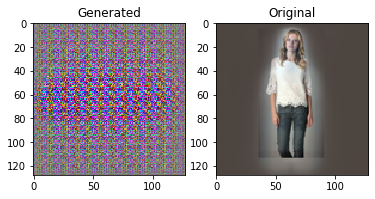

Training epoch 0: discriminator_2_loss = 0.79988, generator_2_loss = 0.79383, generator_2_L1loss = 0.10016
Training epoch 0: d_true = 0.79382, d_notmatch = 0.24086, d_fake = 0.56507


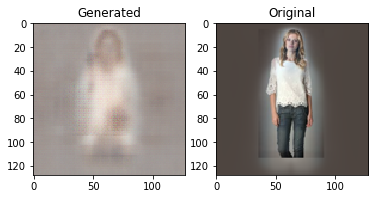

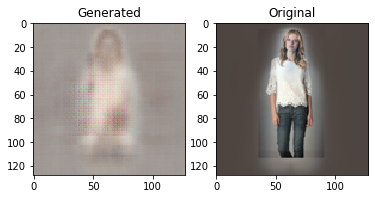

Training epoch 1: discriminator_2_loss = 0.79988, generator_2_loss = 0.79295, generator_2_L1loss = 0.09454
Training epoch 1: d_true = 0.79382, d_notmatch = 0.24086, d_fake = 0.56507


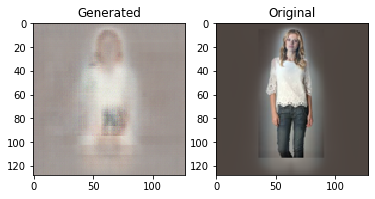

Training epoch 2: discriminator_2_loss = 0.80230, generator_2_loss = 0.79280, generator_2_L1loss = 0.09262
Training epoch 2: d_true = 0.80535, d_notmatch = 0.24313, d_fake = 0.55611


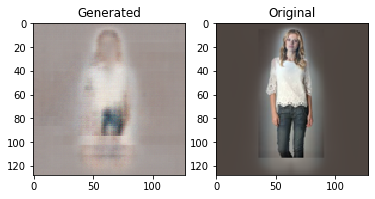

Training epoch 3: discriminator_2_loss = 0.80230, generator_2_loss = 0.79255, generator_2_L1loss = 0.09165
Training epoch 3: d_true = 0.80535, d_notmatch = 0.24313, d_fake = 0.55611


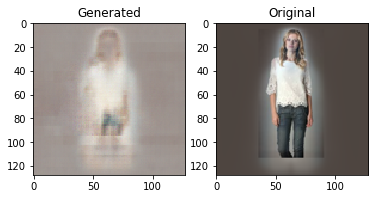

Training epoch 4: discriminator_2_loss = 0.80410, generator_2_loss = 0.79244, generator_2_L1loss = 0.09103
Training epoch 4: d_true = 0.80849, d_notmatch = 0.24247, d_fake = 0.55725


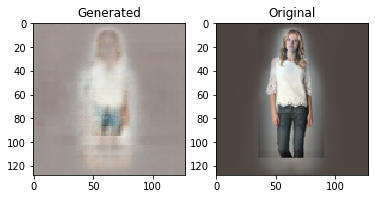

Training epoch 5: discriminator_2_loss = 0.80410, generator_2_loss = 0.79246, generator_2_L1loss = 0.09057
Training epoch 5: d_true = 0.80849, d_notmatch = 0.24247, d_fake = 0.55725


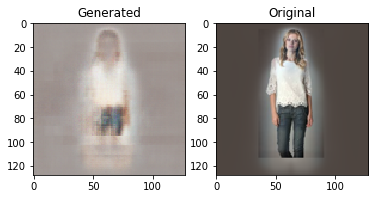

Training epoch 6: discriminator_2_loss = 0.79877, generator_2_loss = 0.79246, generator_2_L1loss = 0.09029
Training epoch 6: d_true = 0.80493, d_notmatch = 0.23817, d_fake = 0.55444


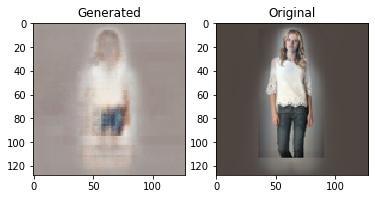

Training epoch 7: discriminator_2_loss = 0.79877, generator_2_loss = 0.79238, generator_2_L1loss = 0.09000
Training epoch 7: d_true = 0.80493, d_notmatch = 0.23817, d_fake = 0.55444


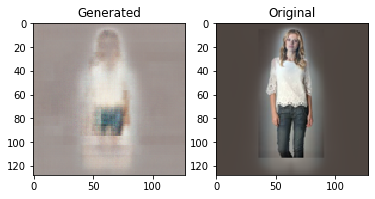

Training epoch 8: discriminator_2_loss = 0.80013, generator_2_loss = 0.79233, generator_2_L1loss = 0.08981
Training epoch 8: d_true = 0.80772, d_notmatch = 0.23848, d_fake = 0.55405


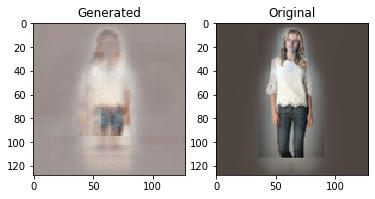

Training epoch 9: discriminator_2_loss = 0.80013, generator_2_loss = 0.79237, generator_2_L1loss = 0.08959
Training epoch 9: d_true = 0.80772, d_notmatch = 0.23848, d_fake = 0.55405


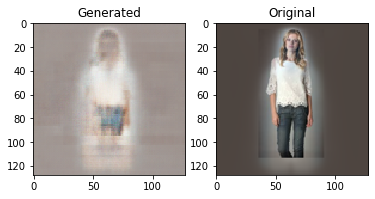

Training epoch 10: discriminator_2_loss = 0.79915, generator_2_loss = 0.79231, generator_2_L1loss = 0.08944
Training epoch 10: d_true = 0.79282, d_notmatch = 0.24281, d_fake = 0.56268


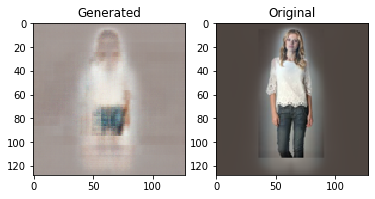

Training epoch 11: discriminator_2_loss = 0.79915, generator_2_loss = 0.79221, generator_2_L1loss = 0.08929
Training epoch 11: d_true = 0.79282, d_notmatch = 0.24281, d_fake = 0.56268


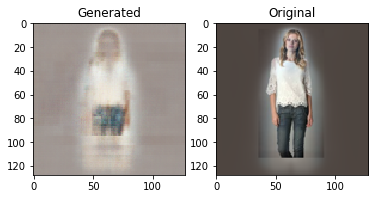

Training epoch 12: discriminator_2_loss = 0.80362, generator_2_loss = 0.79220, generator_2_L1loss = 0.08917
Training epoch 12: d_true = 0.80532, d_notmatch = 0.24173, d_fake = 0.56018


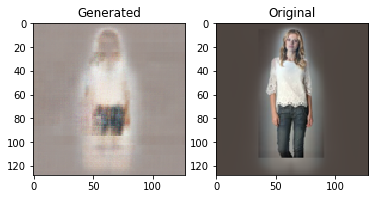

Training epoch 13: discriminator_2_loss = 0.80362, generator_2_loss = 0.79212, generator_2_L1loss = 0.08902
Training epoch 13: d_true = 0.80532, d_notmatch = 0.24173, d_fake = 0.56018


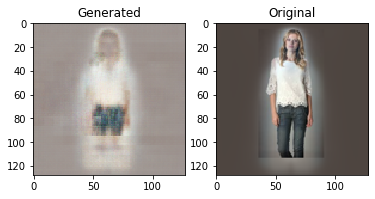

Training epoch 14: discriminator_2_loss = 0.80541, generator_2_loss = 0.79211, generator_2_L1loss = 0.08891
Training epoch 14: d_true = 0.81057, d_notmatch = 0.24325, d_fake = 0.55700


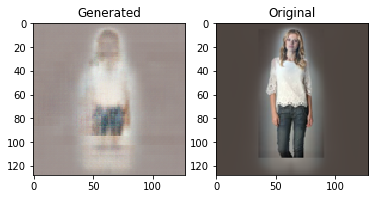

Training epoch 15: discriminator_2_loss = 0.80541, generator_2_loss = 0.79213, generator_2_L1loss = 0.08882
Training epoch 15: d_true = 0.81057, d_notmatch = 0.24325, d_fake = 0.55700


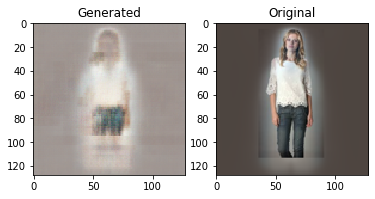

Training epoch 16: discriminator_2_loss = 0.79757, generator_2_loss = 0.79218, generator_2_L1loss = 0.08874
Training epoch 16: d_true = 0.80090, d_notmatch = 0.24029, d_fake = 0.55395


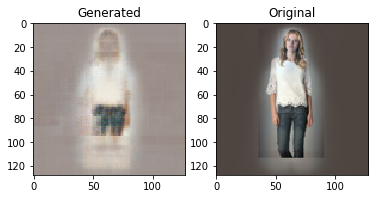

Training epoch 17: discriminator_2_loss = 0.79757, generator_2_loss = 0.79210, generator_2_L1loss = 0.08861
Training epoch 17: d_true = 0.80090, d_notmatch = 0.24029, d_fake = 0.55395


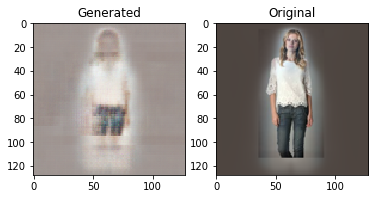

Training epoch 18: discriminator_2_loss = 0.79701, generator_2_loss = 0.79207, generator_2_L1loss = 0.08857
Training epoch 18: d_true = 0.80103, d_notmatch = 0.23890, d_fake = 0.55408


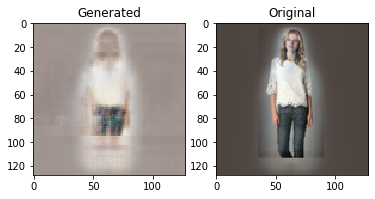

Training epoch 19: discriminator_2_loss = 0.79701, generator_2_loss = 0.79207, generator_2_L1loss = 0.08851
Training epoch 19: d_true = 0.80103, d_notmatch = 0.23890, d_fake = 0.55408


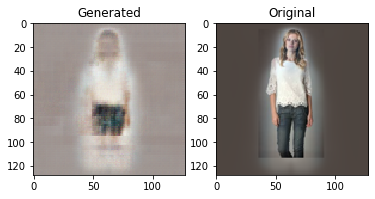

Training epoch 20: discriminator_2_loss = 0.79892, generator_2_loss = 0.79220, generator_2_L1loss = 0.08847
Training epoch 20: d_true = 0.79531, d_notmatch = 0.23874, d_fake = 0.56379


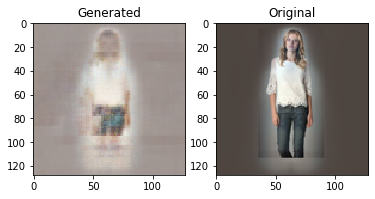

Training epoch 21: discriminator_2_loss = 0.79892, generator_2_loss = 0.79214, generator_2_L1loss = 0.08836
Training epoch 21: d_true = 0.79531, d_notmatch = 0.23874, d_fake = 0.56379


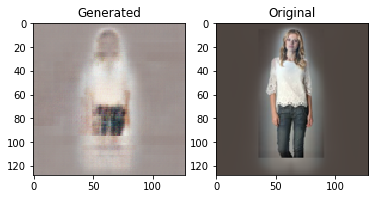

Training epoch 22: discriminator_2_loss = 0.79717, generator_2_loss = 0.79200, generator_2_L1loss = 0.08825
Training epoch 22: d_true = 0.79895, d_notmatch = 0.24138, d_fake = 0.55401


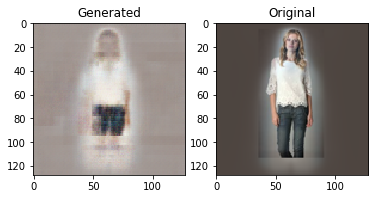

Training epoch 23: discriminator_2_loss = 0.79717, generator_2_loss = 0.79201, generator_2_L1loss = 0.08818
Training epoch 23: d_true = 0.79895, d_notmatch = 0.24138, d_fake = 0.55401


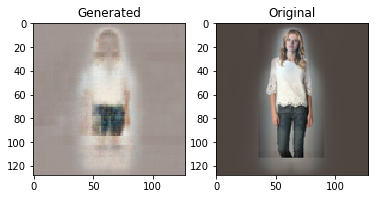

Training epoch 24: discriminator_2_loss = 0.80247, generator_2_loss = 0.79205, generator_2_L1loss = 0.08817
Training epoch 24: d_true = 0.80894, d_notmatch = 0.24183, d_fake = 0.55416


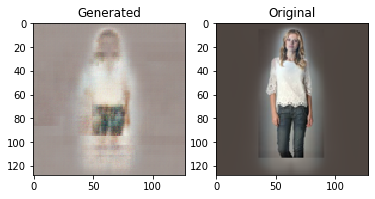

Training epoch 25: discriminator_2_loss = 0.80247, generator_2_loss = 0.79201, generator_2_L1loss = 0.08808
Training epoch 25: d_true = 0.80894, d_notmatch = 0.24183, d_fake = 0.55416


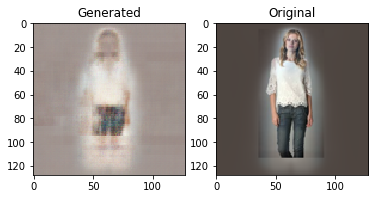

Training epoch 26: discriminator_2_loss = 0.79425, generator_2_loss = 0.79200, generator_2_L1loss = 0.08796
Training epoch 26: d_true = 0.79387, d_notmatch = 0.23801, d_fake = 0.55661


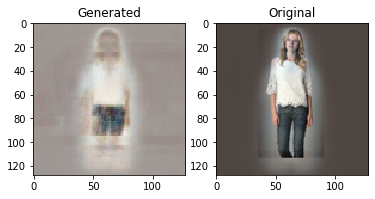

Training epoch 27: discriminator_2_loss = 0.79425, generator_2_loss = 0.79199, generator_2_L1loss = 0.08788
Training epoch 27: d_true = 0.79387, d_notmatch = 0.23801, d_fake = 0.55661


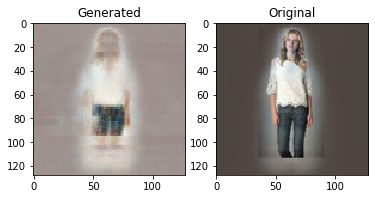

Training epoch 28: discriminator_2_loss = 0.80415, generator_2_loss = 0.79190, generator_2_L1loss = 0.08778
Training epoch 28: d_true = 0.80456, d_notmatch = 0.24103, d_fake = 0.56271


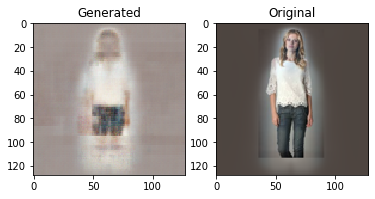

Training epoch 29: discriminator_2_loss = 0.80415, generator_2_loss = 0.79192, generator_2_L1loss = 0.08770
Training epoch 29: d_true = 0.80456, d_notmatch = 0.24103, d_fake = 0.56271


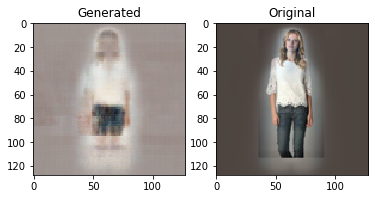

Training epoch 30: discriminator_2_loss = 0.80076, generator_2_loss = 0.79191, generator_2_L1loss = 0.08767
Training epoch 30: d_true = 0.80557, d_notmatch = 0.24193, d_fake = 0.55403


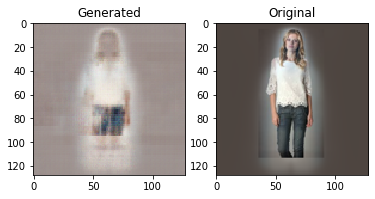

Training epoch 31: discriminator_2_loss = 0.80076, generator_2_loss = 0.79193, generator_2_L1loss = 0.08766
Training epoch 31: d_true = 0.80557, d_notmatch = 0.24193, d_fake = 0.55403


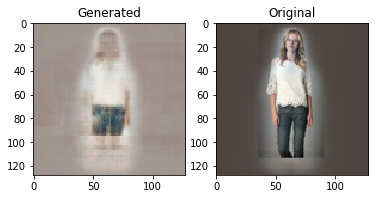

Training epoch 32: discriminator_2_loss = 0.80071, generator_2_loss = 0.79191, generator_2_L1loss = 0.08752
Training epoch 32: d_true = 0.80211, d_notmatch = 0.23768, d_fake = 0.56163


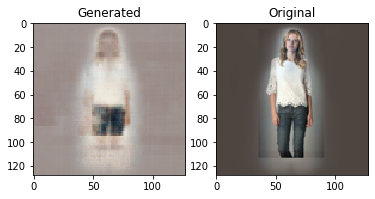

Training epoch 33: discriminator_2_loss = 0.80071, generator_2_loss = 0.79193, generator_2_L1loss = 0.08745
Training epoch 33: d_true = 0.80211, d_notmatch = 0.23768, d_fake = 0.56163


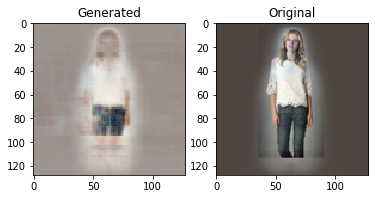

Training epoch 34: discriminator_2_loss = 0.79807, generator_2_loss = 0.79200, generator_2_L1loss = 0.08748
Training epoch 34: d_true = 0.79957, d_notmatch = 0.24236, d_fake = 0.55421


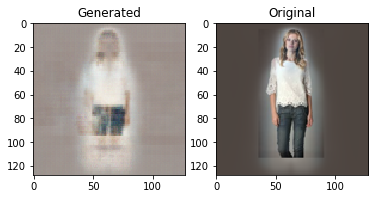

Training epoch 35: discriminator_2_loss = 0.79807, generator_2_loss = 0.79194, generator_2_L1loss = 0.08744
Training epoch 35: d_true = 0.79957, d_notmatch = 0.24236, d_fake = 0.55421


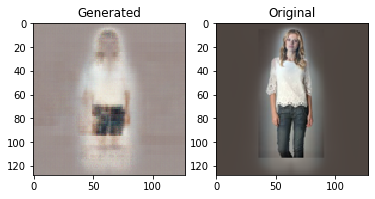

Training epoch 36: discriminator_2_loss = 0.80095, generator_2_loss = 0.79203, generator_2_L1loss = 0.08738
Training epoch 36: d_true = 0.80839, d_notmatch = 0.23830, d_fake = 0.55520


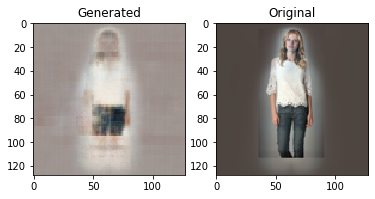

Training epoch 37: discriminator_2_loss = 0.80095, generator_2_loss = 0.79200, generator_2_L1loss = 0.08729
Training epoch 37: d_true = 0.80839, d_notmatch = 0.23830, d_fake = 0.55520


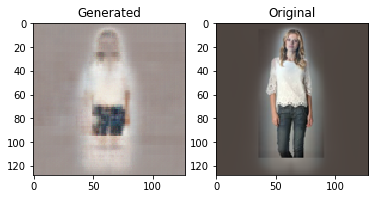

Training epoch 38: discriminator_2_loss = 0.79935, generator_2_loss = 0.79201, generator_2_L1loss = 0.08723
Training epoch 38: d_true = 0.80578, d_notmatch = 0.23892, d_fake = 0.55400


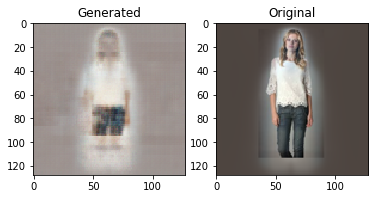

Training epoch 39: discriminator_2_loss = 0.79935, generator_2_loss = 0.79202, generator_2_L1loss = 0.08718
Training epoch 39: d_true = 0.80578, d_notmatch = 0.23892, d_fake = 0.55400


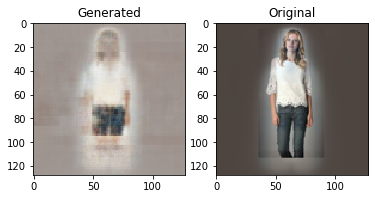

Training epoch 40: discriminator_2_loss = 0.79330, generator_2_loss = 0.79196, generator_2_L1loss = 0.08712
Training epoch 40: d_true = 0.79339, d_notmatch = 0.23926, d_fake = 0.55395


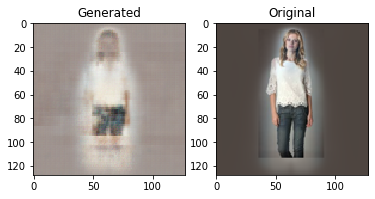

Training epoch 41: discriminator_2_loss = 0.79330, generator_2_loss = 0.79200, generator_2_L1loss = 0.08707
Training epoch 41: d_true = 0.79339, d_notmatch = 0.23926, d_fake = 0.55395


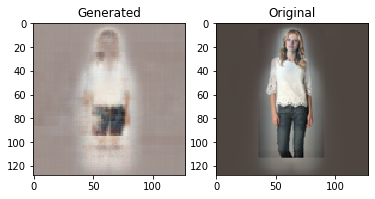

Training epoch 42: discriminator_2_loss = 0.80355, generator_2_loss = 0.79202, generator_2_L1loss = 0.08704
Training epoch 42: d_true = 0.80223, d_notmatch = 0.24325, d_fake = 0.56161


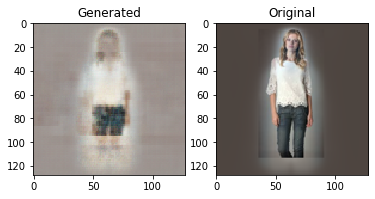

Training epoch 43: discriminator_2_loss = 0.80355, generator_2_loss = 0.79201, generator_2_L1loss = 0.08701
Training epoch 43: d_true = 0.80223, d_notmatch = 0.24325, d_fake = 0.56161


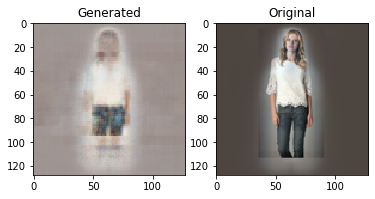

Training epoch 44: discriminator_2_loss = 0.80080, generator_2_loss = 0.79192, generator_2_L1loss = 0.08688
Training epoch 44: d_true = 0.80438, d_notmatch = 0.24257, d_fake = 0.55465


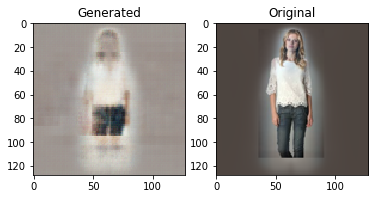

Training epoch 45: discriminator_2_loss = 0.80080, generator_2_loss = 0.79190, generator_2_L1loss = 0.08681
Training epoch 45: d_true = 0.80438, d_notmatch = 0.24257, d_fake = 0.55465


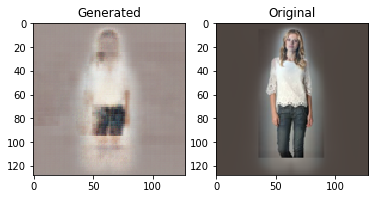

Training epoch 46: discriminator_2_loss = 0.79809, generator_2_loss = 0.79194, generator_2_L1loss = 0.08681
Training epoch 46: d_true = 0.80118, d_notmatch = 0.24089, d_fake = 0.55412


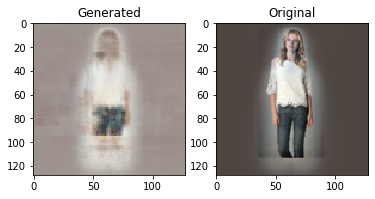

Training epoch 47: discriminator_2_loss = 0.79809, generator_2_loss = 0.79191, generator_2_L1loss = 0.08673
Training epoch 47: d_true = 0.80118, d_notmatch = 0.24089, d_fake = 0.55412


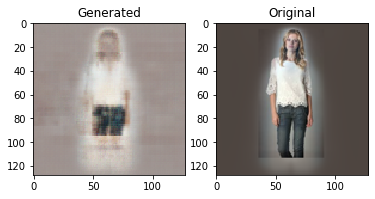

Training epoch 48: discriminator_2_loss = 0.79749, generator_2_loss = 0.79192, generator_2_L1loss = 0.08677
Training epoch 48: d_true = 0.80265, d_notmatch = 0.23809, d_fake = 0.55425


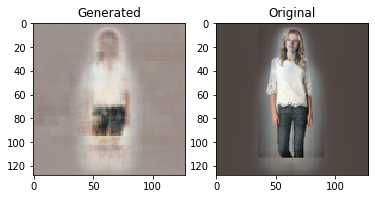

Training epoch 49: discriminator_2_loss = 0.79749, generator_2_loss = 0.79187, generator_2_L1loss = 0.08671
Training epoch 49: d_true = 0.80265, d_notmatch = 0.23809, d_fake = 0.55425


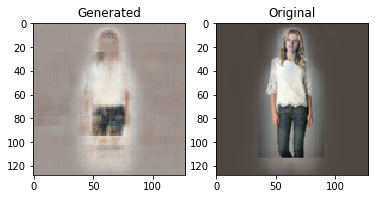

Training epoch 50: discriminator_2_loss = 0.80174, generator_2_loss = 0.79196, generator_2_L1loss = 0.08665
Training epoch 50: d_true = 0.80542, d_notmatch = 0.24329, d_fake = 0.55477


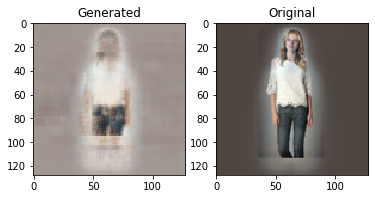

Training epoch 51: discriminator_2_loss = 0.80174, generator_2_loss = 0.79196, generator_2_L1loss = 0.08660
Training epoch 51: d_true = 0.80542, d_notmatch = 0.24329, d_fake = 0.55477


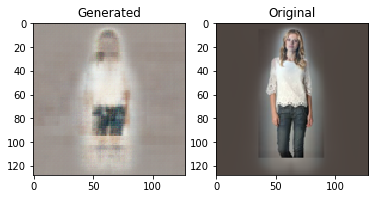

Training epoch 52: discriminator_2_loss = 0.80074, generator_2_loss = 0.79203, generator_2_L1loss = 0.08652
Training epoch 52: d_true = 0.80705, d_notmatch = 0.24031, d_fake = 0.55413


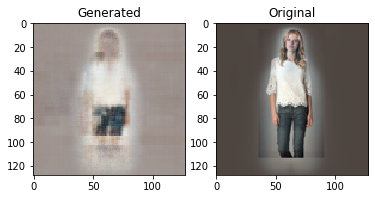

Training epoch 53: discriminator_2_loss = 0.80074, generator_2_loss = 0.79194, generator_2_L1loss = 0.08653
Training epoch 53: d_true = 0.80705, d_notmatch = 0.24031, d_fake = 0.55413


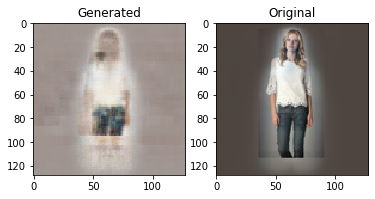

Training epoch 54: discriminator_2_loss = 0.80158, generator_2_loss = 0.79188, generator_2_L1loss = 0.08640
Training epoch 54: d_true = 0.80729, d_notmatch = 0.24169, d_fake = 0.55418


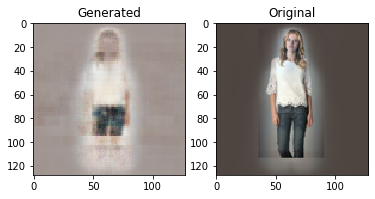

Training epoch 55: discriminator_2_loss = 0.80158, generator_2_loss = 0.79191, generator_2_L1loss = 0.08640
Training epoch 55: d_true = 0.80729, d_notmatch = 0.24169, d_fake = 0.55418


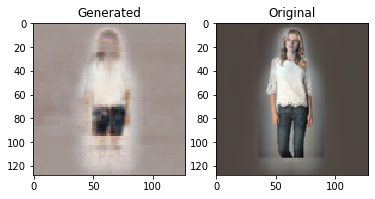

Training epoch 56: discriminator_2_loss = 0.79849, generator_2_loss = 0.79199, generator_2_L1loss = 0.08629
Training epoch 56: d_true = 0.79387, d_notmatch = 0.23999, d_fake = 0.56312


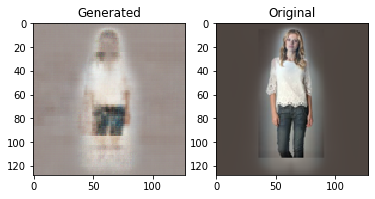

Training epoch 57: discriminator_2_loss = 0.79849, generator_2_loss = 0.79189, generator_2_L1loss = 0.08621
Training epoch 57: d_true = 0.79387, d_notmatch = 0.23999, d_fake = 0.56312


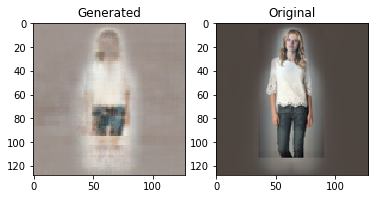

Training epoch 58: discriminator_2_loss = 0.79447, generator_2_loss = 0.79196, generator_2_L1loss = 0.08618
Training epoch 58: d_true = 0.79275, d_notmatch = 0.24205, d_fake = 0.55414


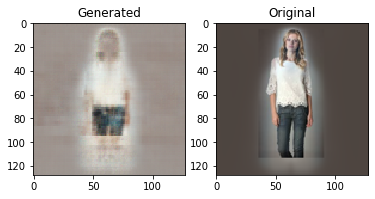

Training epoch 59: discriminator_2_loss = 0.79447, generator_2_loss = 0.79188, generator_2_L1loss = 0.08611
Training epoch 59: d_true = 0.79275, d_notmatch = 0.24205, d_fake = 0.55414


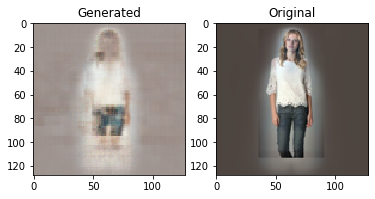

Training epoch 60: discriminator_2_loss = 0.80066, generator_2_loss = 0.79182, generator_2_L1loss = 0.08606
Training epoch 60: d_true = 0.80483, d_notmatch = 0.24246, d_fake = 0.55402


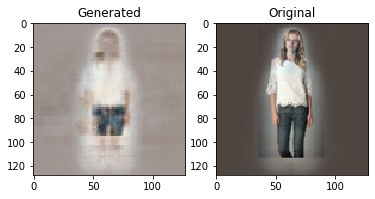

Training epoch 61: discriminator_2_loss = 0.80066, generator_2_loss = 0.79184, generator_2_L1loss = 0.08600
Training epoch 61: d_true = 0.80483, d_notmatch = 0.24246, d_fake = 0.55402


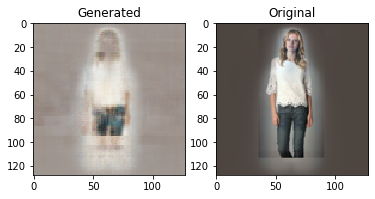

Training epoch 62: discriminator_2_loss = 0.79353, generator_2_loss = 0.79191, generator_2_L1loss = 0.08595
Training epoch 62: d_true = 0.79385, d_notmatch = 0.23828, d_fake = 0.55493


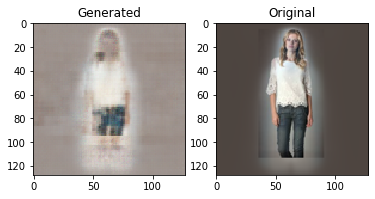

Training epoch 63: discriminator_2_loss = 0.79353, generator_2_loss = 0.79180, generator_2_L1loss = 0.08588
Training epoch 63: d_true = 0.79385, d_notmatch = 0.23828, d_fake = 0.55493


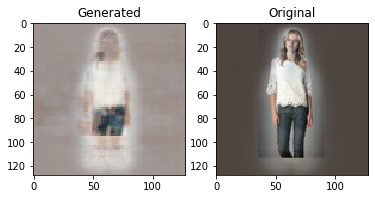

Training epoch 64: discriminator_2_loss = 0.79650, generator_2_loss = 0.79184, generator_2_L1loss = 0.08588
Training epoch 64: d_true = 0.79704, d_notmatch = 0.24176, d_fake = 0.55420


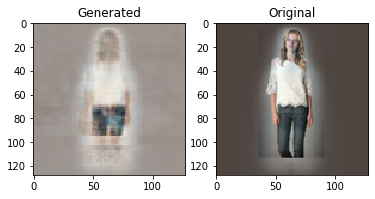

Training epoch 65: discriminator_2_loss = 0.79650, generator_2_loss = 0.79174, generator_2_L1loss = 0.08583
Training epoch 65: d_true = 0.79704, d_notmatch = 0.24176, d_fake = 0.55420


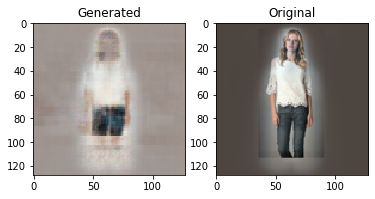

Training epoch 66: discriminator_2_loss = 0.79832, generator_2_loss = 0.79198, generator_2_L1loss = 0.08579
Training epoch 66: d_true = 0.79946, d_notmatch = 0.24262, d_fake = 0.55455


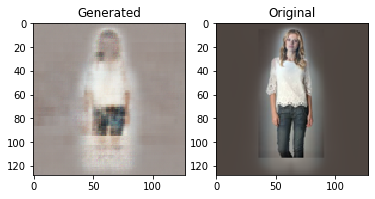

Training epoch 67: discriminator_2_loss = 0.79832, generator_2_loss = 0.79169, generator_2_L1loss = 0.08572
Training epoch 67: d_true = 0.79946, d_notmatch = 0.24262, d_fake = 0.55455


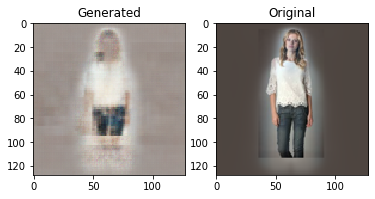

Training epoch 68: discriminator_2_loss = 0.79399, generator_2_loss = 0.79178, generator_2_L1loss = 0.08576
Training epoch 68: d_true = 0.79351, d_notmatch = 0.23988, d_fake = 0.55459


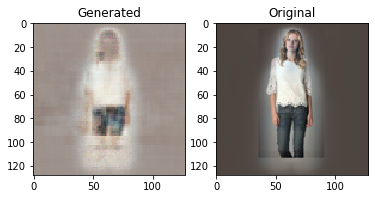

Training epoch 69: discriminator_2_loss = 0.79399, generator_2_loss = 0.79177, generator_2_L1loss = 0.08574
Training epoch 69: d_true = 0.79351, d_notmatch = 0.23988, d_fake = 0.55459


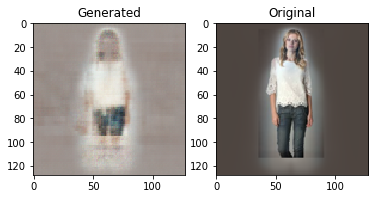

Training epoch 70: discriminator_2_loss = 0.79782, generator_2_loss = 0.79186, generator_2_L1loss = 0.08580
Training epoch 70: d_true = 0.79902, d_notmatch = 0.24201, d_fake = 0.55461


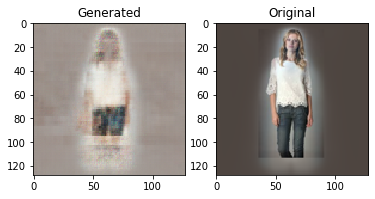

Training epoch 71: discriminator_2_loss = 0.79782, generator_2_loss = 0.79185, generator_2_L1loss = 0.08577
Training epoch 71: d_true = 0.79902, d_notmatch = 0.24201, d_fake = 0.55461


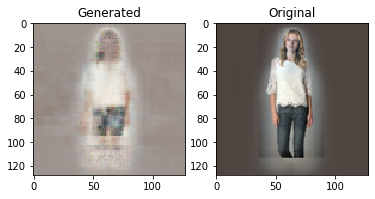

Training epoch 72: discriminator_2_loss = 0.80594, generator_2_loss = 0.79178, generator_2_L1loss = 0.08566
Training epoch 72: d_true = 0.80982, d_notmatch = 0.24277, d_fake = 0.55929


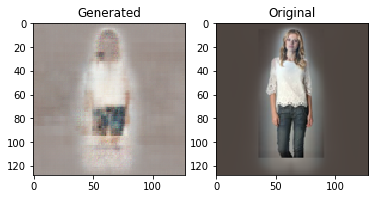

Training epoch 73: discriminator_2_loss = 0.80594, generator_2_loss = 0.79175, generator_2_L1loss = 0.08561
Training epoch 73: d_true = 0.80982, d_notmatch = 0.24277, d_fake = 0.55929


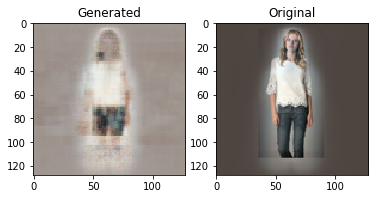

Training epoch 74: discriminator_2_loss = 0.79599, generator_2_loss = 0.79170, generator_2_L1loss = 0.08548
Training epoch 74: d_true = 0.79589, d_notmatch = 0.23759, d_fake = 0.55850


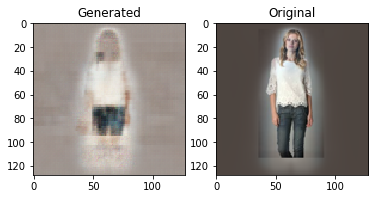

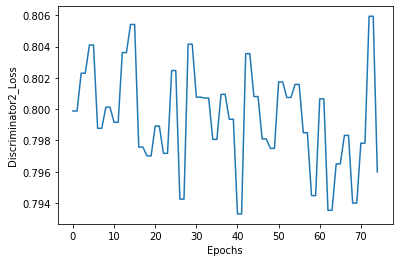

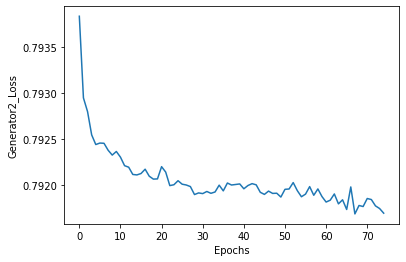

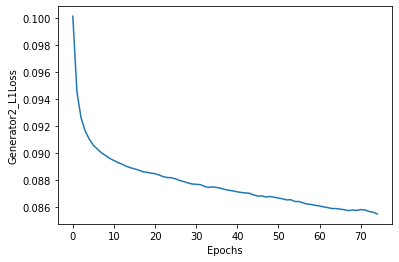

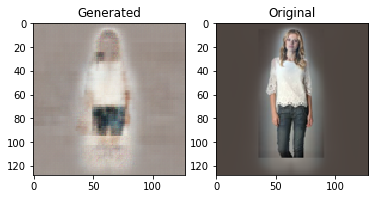

In [0]:
# # load the data
# from torch.autograd import Variable
# import numpy as np
# import os
# from torch.utils.data import DataLoader

# from torch.optim.lr_scheduler import LambdaLR


# cuda = torch.cuda.is_available()
# device = torch.device("cuda:0" if cuda else "cpu")
# X, y = None,None

# loaded_data = None
# # if os.path.isfile(os.path.join(os.path.dirname(__file__),'..','data','debug_data_10k.pkl')):
# #     with open(os.path.join(os.path.dirname(__file__),'..','data','debug_data_10k.pkl'),'rb') as handle:

# if True:
#     with open("/content/drive/My Drive/FashionData/debug_data_50k/debug_data_50k.pkl",'rb') as f:
#         print("I pickle")
#         loaded_data = pickle.load(f)
#         # X,y = pickle.load(handle)
#         X,y = loaded_data[0],loaded_data[1]
# else:
#     # X, y = load_data()
#     print("we don't have data in the drive")
# training_data = FashionData(X,y,'train')
# testing_data = FashionData(X,y,'test')

batch_size = 10

train_loader = DataLoader(training_data, batch_size=batch_size,pin_memory=cuda,shuffle=True)
test_loader  = DataLoader(testing_data, batch_size=batch_size, pin_memory=cuda,shuffle=True)


print("Using device:", device)

G2 = Generator2()
D2 = Discriminator2()
if cuda:
    G2.cuda()
    D2.cuda()

loss_pix = torch.nn.L1Loss()
loss_GAN2 = torch.nn.BCELoss()
print("Using device:", device)



num_epochs = 75




discriminator_2_loss, generator_2_loss, generator_2_L1loss,discriminator_2_loss_true,discriminator_2_loss_fake,discriminator_2_loss_notmatch  = [], [], [],[],[],[]

for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss, batch_g_L1loss,batch_d_loss_true,batch_d_loss_fake,batch_d_loss_notmatch = [], [], [],[],[],[]
    lr = 0.001

    for i , data in enumerate(train_loader, 0):
        generator_2_optim = torch.optim.Adam(G2.parameters(), lr, betas=(0.5, 0.999))
        discriminator_2_optim = torch.optim.Adam(D2.parameters(), lr/30, betas=(0.5, 0.999))
        
        
        #need: I0:original image
        d, mS0, S0, label = data
        
        soft_label = torch.randn(1,1,1)/100
        true_label = (torch.ones(batch_size, 1,1,1)-0.1-soft_label).to(device)
        fake_label = (torch.zeros(batch_size, 1,1,1)+0.1+soft_label).to(device)
        true_label_G = torch.ones(batch_size, 1,1,1).to(device)
        

        if(0 == i and 0 == epoch%2):

          D2.zero_grad()  
          
          #################### Update D #############################
          noise_mask = torch.randn(batch_size,3,128,128)/10#add some noise to the input of D
          # loss 1. real image + real condition -> 1
          x_true_S0 = Variable(S0).to(device,dtype=torch.float)
          x_true_I0 = Variable(label+noise_mask).to(device,dtype=torch.float)
          x_true_d = Variable(d).to(device,dtype=torch.float)        
          output = D2.forward(x_true_d,x_true_I0,x_true_S0)
          
          error_true = loss_GAN2(output, true_label) 
          # loss 2. sampled real image + wrong condition -> 0  
          sample_I = np.zeros((batch_size,3,128,128))
          sample_S0 = np.zeros((batch_size,7,128,128))
          for bs in range(batch_size):
            rnd = np.random.randint(0,len(y['train']))
            sample_I[bs] = y['train'][rnd]
            sample_S0[bs] = get_segmented_image_7(X['train']['segmented_image'][rnd])
          x_notmatch_I = Variable(torch.from_numpy(sample_I)+noise_mask).to(device,dtype=torch.float)
          x_notmatch_S0 = Variable(torch.from_numpy(sample_S0)).to(device,dtype=torch.float)  
          # x_notmatch_d = x_true_d[torch.randperm(x_true_d.size()[0])] # another way: shuffle d
          x_notmatch_d = Variable(d).to(device,dtype=torch.float)    
          # x_notmatch_d = Variable(x_notmatch_d).to(device)    
          output = D2.forward(x_notmatch_d ,x_true_I0,x_notmatch_S0)

          error_notmatch = 0.3*loss_GAN2(output, fake_label) 

          # loss 3. generated fake image + real condition -> 0s
          z = torch.randn(batch_size, gausian_noise_size,dtype=torch.float64)
          dz = torch.cat([d, z] , dim=1)
          dz = dz.view((batch_size,dz.shape[1],1,1))
          dz = Variable(dz).to(device,dtype=torch.float)
          x_true_S0_g = Variable(S0).to(device,dtype=torch.float)
          
          I_tilde = G2.forward(dz,x_true_S0_g)

          x_fake_I = (I_tilde.cpu()+noise_mask).to(device,dtype=torch.float)
          x_fake_d = Variable(d).to(device,dtype=torch.float) 
          output = D2.forward(x_fake_d,x_fake_I.detach(),x_true_S0_g)
          

          error_fake = 0.7*loss_GAN2(output, fake_label)
          err_D = error_true+error_fake+error_notmatch
          err_D.backward()
          discriminator_2_optim.step()

              
        
        #################### Update G #############################
        G2.zero_grad()

        
        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        x_fake_d = Variable(d).to(device,dtype=torch.float)
        z = torch.randn(batch_size, gausian_noise_size,dtype=torch.float64)
        dz = torch.cat([d, z] , dim=1)
        dz = dz.view((batch_size,dz.shape[1],1,1))
        dz = Variable(dz).to(device,dtype=torch.float)
        x_true_S0_g = Variable(S0).to(device,dtype=torch.float)
        
        I_tilde = G2.forward(dz,x_true_S0_g)

        x_fake_I = I_tilde
        
        
        output = D2.forward(x_fake_d,x_fake_I,x_true_S0_g)
        target = Variable(label).to(device,dtype=torch.float)
        error_D = loss_GAN2(output, true_label_G)
        # error_D.backward()
        error_pix = loss_pix(x_fake_I,target) # weak regularization
#         error_pix = 50*loss_pix(x_fake_I,target) # strong regularization
        # error_seg.backward
        error_2_generator = error_pix + error_D
        error_2_generator.backward()
        generator_2_optim.step()
        
        lr = lr * 0.9999
        
        # batch_d_loss.append((error_true/(error_true + error_fake + error_notmatch)).item())
        batch_d_loss.append(0.5*(error_true + error_fake + error_notmatch).item())
        batch_d_loss_true.append(error_true.item())
        batch_d_loss_fake.append(error_fake.item())
        batch_d_loss_notmatch.append(error_notmatch.item())
        batch_g_loss.append(error_D.item())
        batch_g_L1loss.append(error_pix.item())


#         if epoch<2:

#           if i%5000==0:

#             with torch.no_grad():
#                 zsample = torch.randn(gausian_noise_size,dtype=torch.float64)
#                 dsample = []
#                 dsample.append(float(X['train']['gender'][0]))
#                 dsample.extend(binary_representaiton(X['train']['color'][0],5))
#                 dsample.extend(binary_representaiton(X['train']['sleeve'][0],3))
#                 dsample.extend(binary_representaiton(X['train']['cate_new'][0],5))
#                 dsample.append(X['train']['r'][0])
#                 dsample.append(X['train']['g'][0])
#                 dsample.append(X['train']['b'][0])
#                 dsample.append(X['train']['y'][0])
#                 dsample.extend(X['train']['encoding'][0])
#                 dsample = np.array(dsample)
#                 dsample = torch.from_numpy(dsample)
#                 dzsample = torch.cat([dsample,zsample] , dim=0)
#                 dzsample = dzsample.view((1,dzsample.shape[0],1,1))
#                 dzsample = Variable(dzsample).to(device,dtype=torch.float)
#                 S0_sample = get_segmented_image_7(X['train']['segmented_image'][0])
#                 S0_sample = S0_sample.view((1,7,128,128))
#                 S0_sample = Variable(S0_sample).to(device,dtype=torch.float)
#                 I_tilde_sample = G2.forward(dzsample,S0_sample)

#             I_tilde_sample = I_tilde_sample.data.cpu().numpy().T
#             I_tilde_sample =  I_tilde_sample.reshape(128,128,3)
#             fig = plt.figure()
#             ax = fig.add_subplot(121)
#             ax.imshow(I_tilde_sample)
#             ax.set_title("Generated")

#             I_0_sample = y['train'][0]
#             I_0_sample = torch.from_numpy(I_0_sample)
#             I_0_sample = I_0_sample.permute(2,1,0)
#             ax= fig.add_subplot(122)
#             ax.imshow(I_0_sample)
#             ax.set_title("Original")
#             plt.savefig('/content/drive/My Drive/GAN2/i_{}.png'.format(epoch))
#             plt.show()

    discriminator_2_loss.append(np.mean(batch_d_loss))
    generator_2_loss.append(np.mean(batch_g_loss))
    generator_2_L1loss.append(np.mean(batch_g_L1loss))
    discriminator_2_loss_true.append(np.mean(batch_d_loss_true))
    discriminator_2_loss_notmatch.append(np.mean(batch_d_loss_notmatch))
    discriminator_2_loss_fake.append(np.mean(batch_d_loss_fake))
   
    print('Training epoch %d: discriminator_2_loss = %.5f, generator_2_loss = %.5f, generator_2_L1loss = %.5f' % (epoch, discriminator_2_loss[epoch].item(), generator_2_loss[epoch].item(),generator_2_L1loss[epoch].item()))
    print('Training epoch %d: d_true = %.5f, d_notmatch = %.5f, d_fake = %.5f' % (epoch, discriminator_2_loss_true[epoch].item(), discriminator_2_loss_notmatch[epoch].item(),discriminator_2_loss_fake[epoch].item()))

# save image per 5 epoch
    if True:
      with torch.no_grad():
          zsample = torch.randn(gausian_noise_size,dtype=torch.float64)
          dsample = []
          dsample.append(float(X['train']['gender'][0]))
          dsample.extend(binary_representaiton(X['train']['color'][0],5))
          dsample.extend(binary_representaiton(X['train']['sleeve'][0],3))
          dsample.extend(binary_representaiton(X['train']['cate_new'][0],5))
          dsample.append(X['train']['r'][0])
          dsample.append(X['train']['g'][0])
          dsample.append(X['train']['b'][0])
          dsample.append(X['train']['y'][0])
          dsample.extend(X['train']['encoding'][0])
          dsample = np.array(dsample)
          dsample = torch.from_numpy(dsample)
          dzsample = torch.cat([dsample,zsample] , dim=0)
          dzsample = dzsample.view((1,dzsample.shape[0],1,1))
          dzsample = Variable(dzsample).to(device,dtype=torch.float)
          S0_sample = get_segmented_image_7(X['train']['segmented_image'][0])
          S0_sample = S0_sample.view((1,7,128,128))
          S0_sample = Variable(S0_sample).to(device,dtype=torch.float)
          I_tilde_sample = G2.forward(dzsample,S0_sample)

      I_tilde_sample = I_tilde_sample.data.cpu().numpy().T
      I_tilde_sample =  I_tilde_sample.reshape(128,128,3)
      fig = plt.figure()
      ax = fig.add_subplot(121)
      ax.imshow(I_tilde_sample)
      ax.set_title("Generated")

      I_0_sample = y['train'][0]
      I_0_sample = torch.from_numpy(I_0_sample)
      I_0_sample = I_0_sample.permute(2,1,0)
      ax= fig.add_subplot(122)
      ax.imshow(I_0_sample)
      ax.set_title("Original")
      plt.savefig('/content/drive/My Drive/GAN2/epoch{}.png'.format(epoch))
      plt.show()

    # Generate data
# save model
torch.save(G2.state_dict(), '/content/drive/My Drive/G2.pth')
torch.save(D2.state_dict(), '/content/drive/My Drive/D2.pth')
with torch.no_grad():
    zsample = torch.randn(gausian_noise_size,dtype=torch.float64)
    dsample = []
    dsample.append(float(X['train']['gender'][0]))
    dsample.extend(binary_representaiton(X['train']['color'][0],5))
    dsample.extend(binary_representaiton(X['train']['sleeve'][0],3))
    dsample.extend(binary_representaiton(X['train']['cate_new'][0],5))
    dsample.append(X['train']['r'][0])
    dsample.append(X['train']['g'][0])
    dsample.append(X['train']['b'][0])
    dsample.append(X['train']['y'][0])
    dsample.extend(X['train']['encoding'][0])
    dsample = np.array(dsample)
    dsample = torch.from_numpy(dsample)
    dzsample = torch.cat([dsample,zsample] , dim=0)
    dzsample = dzsample.view((1,dzsample.shape[0],1,1))
    dzsample = Variable(dzsample).to(device,dtype=torch.float)
    S0_sample = get_segmented_image_7(X['train']['segmented_image'][0])
    S0_sample = S0_sample.view((1,7,128,128))
    S0_sample = Variable(S0_sample).to(device,dtype=torch.float)
    I_tilde_sample = G2.forward(dzsample,S0_sample)
    
fig1 = plt.figure(1)
plt.plot(range(num_epochs), discriminator_2_loss)
plt.xlabel('Epochs')  
plt.ylabel('Discriminator2_Loss')  
plt.show()
fig2 = plt.figure(2)
plt.plot(range(num_epochs), generator_2_loss)
plt.xlabel('Epochs')  
plt.ylabel('Generator2_Loss')  
plt.show()
fig3 = plt.figure(3)
plt.plot(range(num_epochs), generator_2_L1loss)
plt.xlabel('Epochs')  
plt.ylabel('Generator2_L1Loss') 
plt.show()


I_tilde_sample = I_tilde_sample.data.cpu().numpy().T
I_tilde_sample =  I_tilde_sample.reshape(128,128,3)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(I_tilde_sample)
ax.set_title("Generated")

I_0_sample = y['train'][0]
I_0_sample = torch.from_numpy(I_0_sample)
I_0_sample = I_0_sample.permute(2,1,0)
ax= fig.add_subplot(122)
ax.imshow(I_0_sample)
ax.set_title("Original")
plt.show()


    

# Script for Demo: Fusion With Original Image

In [0]:
######### S0 -> G2 -> I_tilde ###################
def fusion_generation(imageind,dind,noise_size):
  with torch.no_grad():
    zsample = torch.randn(noise_size,dtype=torch.float64)
    dsample = []
    dsample.append(float(X['train']['gender'][dind]))
    dsample.extend(binary_representaiton(X['train']['color'][dind],5))
    dsample.extend(binary_representaiton(X['train']['sleeve'][dind],3))
    dsample.extend(binary_representaiton(X['train']['cate_new'][dind],5))
    dsample.append(X['train']['r'][dind])
    dsample.append(X['train']['g'][dind])
    dsample.append(X['train']['b'][dind])
    dsample.append(X['train']['y'][dind])
    dsample.extend(X['train']['encoding'][dind])
    dsample = np.array(dsample)
    dsample = torch.from_numpy(dsample)
    dzsample = torch.cat([dsample,zsample] , dim=0)
    dzsample = dzsample.view((1,dzsample.shape[0],1,1))
    dzsample = Variable(dzsample).to(device,dtype=torch.float)
    S0_sample = get_segmented_image_7(X['train']['segmented_image'][imageind])
    S0_sample = Variable(S0_sample).to(device,dtype=torch.float)
    S0_sample = S0_sample.view((1,7,128,128))
    I_tilde_sample = G2.forward(dzsample,S0_sample)
    I_tilde_sample = I_tilde_sample.data.cpu().numpy().T
    I_tilde_sample =  I_tilde_sample.reshape(128,128,3)
    I_0_sample = y['train'][imageind]
    I_0_sample = torch.from_numpy(I_0_sample)
    I_0_sample = I_0_sample.permute(2,1,0).numpy()

    mask = np.zeros((128,128,3))
    mask_inv = np.zeros((128,128,3))
    mask_1 = (S0_sample[0][3] + S0_sample[0][6]).cpu().numpy()
    mask_inv_1 = (S0_sample[0][0]+S0_sample[0][1]+S0_sample[0][2]+S0_sample[0][5]+S0_sample[0][4]).cpu().numpy()
    for ch in range(3):
      mask[:,:,ch] = mask_1
      mask_inv[:,:,ch] = mask_inv_1
    cloth = I_tilde_sample * mask
    fusion_image = I_0_sample*mask_inv+cloth 
  return(fusion_image,I_tilde_sample,I_0_sample)

def fusion_generation_test(imageind,dind,noise_size):
  with torch.no_grad():
    zsample = torch.randn(noise_size,dtype=torch.float64)
    dsample = []
    dsample.append(float(X['test']['gender'][dind]))
    dsample.extend(binary_representaiton(X['test']['color'][dind],5))
    dsample.extend(binary_representaiton(X['test']['sleeve'][dind],3))
    dsample.extend(binary_representaiton(X['test']['cate_new'][dind],5))
    dsample.append(X['test']['r'][dind])
    dsample.append(X['test']['g'][dind])
    dsample.append(X['test']['b'][dind])
    dsample.append(X['test']['y'][dind])
    dsample.extend(X['test']['encoding'][dind])
    dsample = np.array(dsample)
    dsample = torch.from_numpy(dsample)
    dzsample = torch.cat([dsample,zsample] , dim=0)
    dzsample = dzsample.view((1,dzsample.shape[0],1,1))
    dzsample = Variable(dzsample).to(device,dtype=torch.float)
    S0_sample = get_segmented_image_7(X['test']['segmented_image'][imageind])
    S0_sample = Variable(S0_sample).to(device,dtype=torch.float)
    S0_sample = S0_sample.view((1,7,128,128))
    I_tilde_sample = G2.forward(dzsample,S0_sample)
    I_tilde_sample = I_tilde_sample.data.cpu().numpy().T
    I_tilde_sample =  I_tilde_sample.reshape(128,128,3)
    I_0_sample = y['test'][imageind]
    I_0_sample = torch.from_numpy(I_0_sample)
    I_0_sample = I_0_sample.permute(2,1,0).numpy()

    mask = np.zeros((128,128,3))
    mask_inv = np.zeros((128,128,3))
    mask_1 = (S0_sample[0][3] + S0_sample[0][6]).cpu().numpy()
    mask_inv_1 = (S0_sample[0][0]+S0_sample[0][1]+S0_sample[0][2]+S0_sample[0][5]+S0_sample[0][4]).cpu().numpy()
    for ch in range(3):
      mask[:,:,ch] = mask_1
      mask_inv[:,:,ch] = mask_inv_1
    cloth = I_tilde_sample * mask
    fusion_image = I_0_sample*mask_inv+cloth 
  return(fusion_image,I_tilde_sample,I_0_sample)
######### 2GAN: G1 -> S_tilde -> G2 -> I_tilde ###################
def fusion_generation_2GAN(imageind,dind,noise_size):
  with torch.no_grad():
    zsample = torch.randn(noise_size,dtype=torch.float64)
    dsample = []
    dsample.append(float(X['train']['gender'][dind]))
    dsample.extend(binary_representaiton(X['train']['color'][dind],5))
    dsample.extend(binary_representaiton(X['train']['sleeve'][dind],3))
    dsample.extend(binary_representaiton(X['train']['cate_new'][dind],5))
    dsample.append(X['train']['r'][dind])
    dsample.append(X['train']['g'][dind])
    dsample.append(X['train']['b'][dind])
    dsample.append(X['train']['y'][dind])
    dsample.extend(X['train']['encoding'][dind])
    dsample = np.array(dsample)
    dsample = torch.from_numpy(dsample)
    dzsample = torch.cat([dsample,zsample] , dim=0)
    dzsample = dzsample.view((1,dzsample.shape[0],1,1))
    dzsample = Variable(dzsample).to(device,dtype=torch.float)
    mS0_sample = X['train']['down_sampled_images'][imageind]
    mS0_sample = mS0_sample.view((1,4,8,8))
    mS0_sample = Variable(mS0_sample).to(device,dtype=torch.float)
    S_tilde_sample = torch.exp(G1.forward(dzsample,mS0_sample))
    S0_sample = S_tilde_sample
    S0_sample = S0_sample.view((1,7,128,128))
    S0 = make_segmentation(S0_sample)
    S0 = torch.from_numpy(S0)
    S0 = Variable(S0).to(device,dtype=torch.float)
    I_tilde_sample = G2.forward(dzsample,S0)
    I_tilde_sample = I_tilde_sample.data.cpu().numpy().T
    I_tilde_sample =  I_tilde_sample.reshape(128,128,3)
    I_0_sample = y['train'][imageind]
    I_0_sample = torch.from_numpy(I_0_sample)
    I_0_sample = I_0_sample.permute(2,1,0).numpy()

    mask = np.zeros((128,128,3))
    mask_inv = np.zeros((128,128,3))
    mask_1 = (S0[0][3] + S0[0][6]).cpu().numpy()
    mask_inv_1 = (S0[0][0]+S0[0][1]+S0[0][2]+S0[0][5]+S0[0][4]).cpu().numpy()
    for ch in range(3):
      mask[:,:,ch] = mask_1
      mask_inv[:,:,ch] = mask_inv_1
    cloth = I_tilde_sample * mask
    fusion_image = I_0_sample*mask_inv+cloth 
  return(fusion_image,I_tilde_sample,I_0_sample)

def fusion_generation_test_2GAN(imageind,dind,noise_size):
  with torch.no_grad():
    zsample = torch.randn(noise_size,dtype=torch.float64)
    dsample = []
    dsample.append(float(X['test']['gender'][dind]))
    dsample.extend(binary_representaiton(X['test']['color'][dind],5))
    dsample.extend(binary_representaiton(X['test']['sleeve'][dind],3))
    dsample.extend(binary_representaiton(X['test']['cate_new'][dind],5))
    dsample.append(X['test']['r'][dind])
    dsample.append(X['test']['g'][dind])
    dsample.append(X['test']['b'][dind])
    dsample.append(X['test']['y'][dind])
    dsample.extend(X['test']['encoding'][dind])
    dsample = np.array(dsample)
    dsample = torch.from_numpy(dsample)
    dzsample = torch.cat([dsample,zsample] , dim=0)
    dzsample = dzsample.view((1,dzsample.shape[0],1,1))
    dzsample = Variable(dzsample).to(device,dtype=torch.float)
    mS0_sample = X['test']['down_sampled_images'][imageind]
    mS0_sample = mS0_sample.view((1,4,8,8))
    mS0_sample = Variable(mS0_sample).to(device,dtype=torch.float)
    S_tilde_sample = torch.exp(G1.forward(dzsample,mS0_sample))
    S0_sample = S_tilde_sample
    S0_sample = Variable(S0_sample).to(device,dtype=torch.float)
    S0_sample = S0_sample.view((1,7,128,128))
    S0 = make_segmentation(S0_sample)
    S0 = torch.from_numpy(S0)
    S0 = Variable(S0).to(device,dtype=torch.float)
    I_tilde_sample = G2.forward(dzsample,S0)
    I_tilde_sample = I_tilde_sample.data.cpu().numpy().T
    I_tilde_sample =  I_tilde_sample.reshape(128,128,3)
    I_0_sample = y['test'][imageind]
    I_0_sample = torch.from_numpy(I_0_sample)
    I_0_sample = I_0_sample.permute(2,1,0).numpy()

    mask = np.zeros((128,128,3))
    mask_inv = np.zeros((128,128,3))
    mask_1 = (S0[0][3] + S0[0][6]).cpu().numpy()
    mask_inv_1 = (S0[0][0]+S0[0][1]+S0[0][2]+S0[0][5]+S0[0][4]).cpu().numpy()
    for ch in range(3):
      mask[:,:,ch] = mask_1
      mask_inv[:,:,ch] = mask_inv_1
    cloth = I_tilde_sample * mask
    fusion_image = I_0_sample*mask_inv+cloth 
  return(fusion_image,I_tilde_sample,I_0_sample)

#input: (1,7,128,128) for each pixel, assign the maximum in 7 channels as 1, others as 0
def make_segmentation(S_tilde):
  S_tilde_new = np.zeros((1,7,128,128))
  for i in range(128):
    for j in range(128):
      maxcnt = 0
      maxind = 0
      for ch in range(7):
        if S_tilde[0][ch][i][j].item() > maxcnt :
          maxcnt = S_tilde[0][ch][i][j].item()
          maxind = ch
      S_tilde_new[0][maxind][i][j] = 1
#   S_tilde_new = S_tilde.cpu().numpy() # only test GAN2
  return S_tilde_new
  

In [0]:
from torch.autograd import Variable
import numpy as np
import os
from torch.utils.data import DataLoader
#how to load the model:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

G1 = Generator1().to(device,dtype=torch.float)
G1.load_state_dict(torch.load('/content/drive/My Drive/G1.pth'))
G2 = Generator2().to(device,dtype=torch.float)
G2.load_state_dict(torch.load('/content/drive/My Drive/G2.pth'))


#######   load the data if you haven't  #######
X, y = None,None

loaded_data = None
# if os.path.isfile(os.path.join(os.path.dirname(__file__),'..','data','debug_data_10k.pkl')):
#     with open(os.path.join(os.path.dirname(__file__),'..','data','debug_data_10k.pkl'),'rb') as handle:

if True:
    with open("/content/drive/My Drive/FashionData/debug_data_50k/debug_data_50k.pkl",'rb') as handle:
        print("I pickle")
        loaded_data = pickle.load(handle)
        X,y = loaded_data[0],loaded_data[1]
else:
    # X, y = load_data()
    print("we don't have data in the drive")

I pickle


In [0]:
############ show some fusion image with original discriptions (training set) ###########
# imageind = 1
# dind = 1
# for imageind in range(500):
#   fusion,I_tilde,I_0 = fusion_generation(imageind,dind,gausian_noise_size)
#   plt.imshow(fusion)
#   print(imageind,X['train']['description'][dind])
#   plt.show()    


############ show some fusion image with original discriptions (test set) ###########
# for imageind in range(999):
#   # fusion,I_tilde,I_0 = fusion_generation_test(imageind,dind,gausian_noise_size)
#   # plt.imshow(fusion)
#   # print(imageind,X['test']['description'][dind])
#   # plt.show()    
#   dind = imageind
#   #####training data######
#   # fusion,I_tilde,I_0 = fusion_generation(imageind,dind,gausian_noise_size)
#   # fusion_,I_tilde_,I_0_ = fusion_generation(imageind,imageind,gausian_noise_size)
#   fusion,I_tilde,I_0 = fusion_generation_test(imageind,dind,gausian_noise_size)
#   fusion_,I_tilde_,I_0_ = fusion_generation_test(imageind,imageind,gausian_noise_size)
#   fig = plt.figure()
#   ax = fig.add_subplot(111)
#   ax.imshow(fusion)
#   ax.set_xticks([])
#   ax.set_yticks([])
#   print(imageind,X['test']['description'][dind])
#   plt.show()    

40 the lady was wearing a blue short-sleeved blouse.


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:330: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


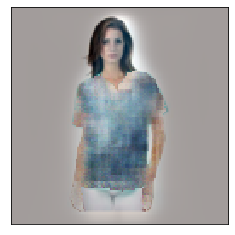

40 the lady was wearing a pink sleeveless blouse.


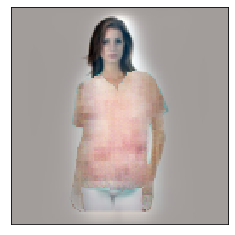

40 the lady was wearing a white short-sleeved blouse.


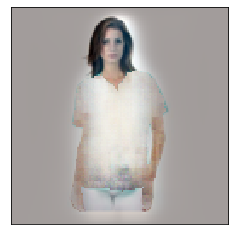

40 the lady is wearing a white sleeveless blouse.


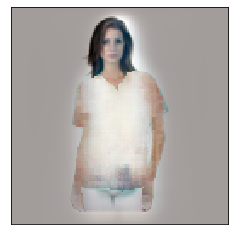

40 the lady was wearing a blue long-sleeved blouse.


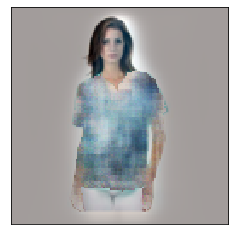

667 the lady was wearing a blue short-sleeved blouse.


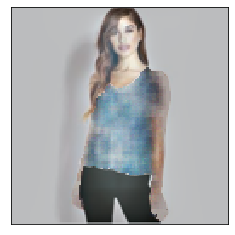

667 the lady was wearing a pink sleeveless blouse.


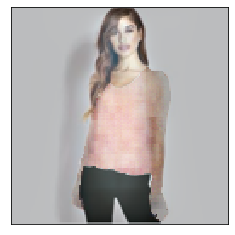

667 the lady was wearing a white short-sleeved blouse.


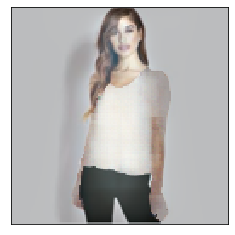

667 the lady is wearing a white sleeveless blouse.


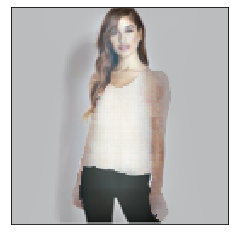

667 the lady was wearing a blue long-sleeved blouse.


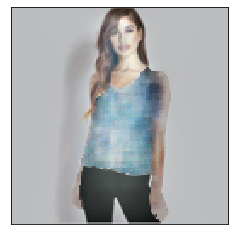

235 the lady was wearing a blue short-sleeved blouse.


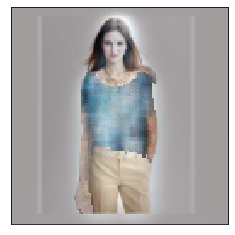

235 the lady was wearing a pink sleeveless blouse.


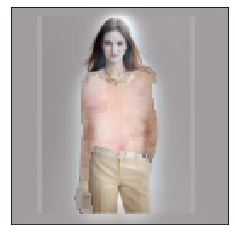

235 the lady was wearing a white short-sleeved blouse.


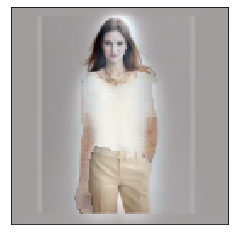

235 the lady is wearing a white sleeveless blouse.


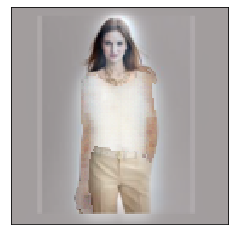

235 the lady was wearing a blue long-sleeved blouse.


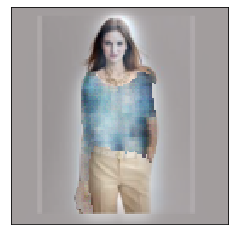

115 the lady was wearing a blue short-sleeved blouse.


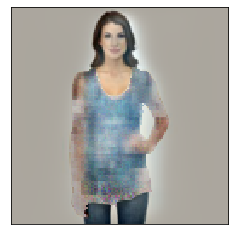

115 the lady was wearing a pink sleeveless blouse.


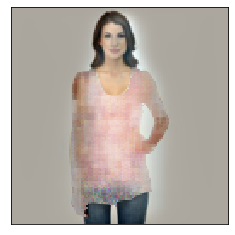

115 the lady was wearing a white short-sleeved blouse.


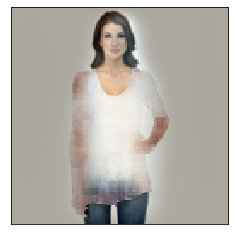

115 the lady is wearing a white sleeveless blouse.


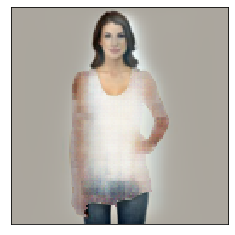

115 the lady was wearing a blue long-sleeved blouse.


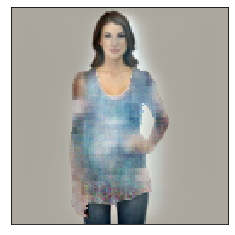

90 the lady was wearing a blue short-sleeved blouse.


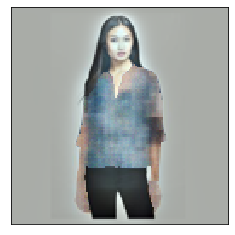

90 the lady was wearing a pink sleeveless blouse.


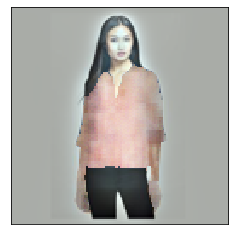

90 the lady was wearing a white short-sleeved blouse.


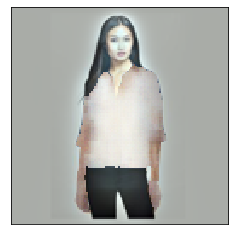

90 the lady is wearing a white sleeveless blouse.


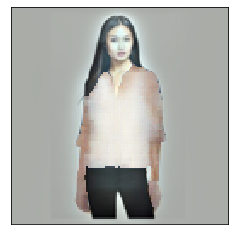

90 the lady was wearing a blue long-sleeved blouse.


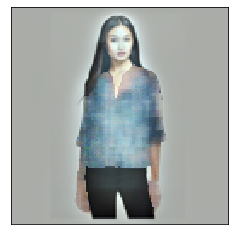

In [0]:
# samples for the result matrix
list = [40,667,235,115,90]

for imageind in list: 
  for dind in list:
    fusion,I_tilde,I_0 = fusion_generation_test(imageind,dind,gausian_noise_size)
    fusion_,I_tilde_,I_0_ = fusion_generation_test(imageind,imageind,gausian_noise_size)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(fusion)
    ax.set_xticks([])
    ax.set_yticks([])
    print(imageind,X['test']['description'][dind])
    plt.show()   